#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**


In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

/tmp/ipykernel_4229/1977922472.py:115: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(self.normal_dist(feature_value, mean, std))
/tmp/ipykernel_4229/1977922472.py:115: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(self.normal_dist(feature_value, mean, std))


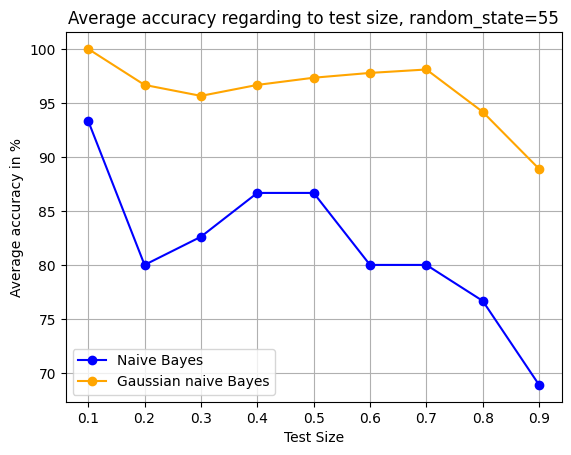

In [ ]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


iris = load_iris()

x = iris.data
x = np.array(x)
y = iris.target
y = np.array(y)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)


class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}


    def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
        IRIS_CLASSES = {0, 1, 2}
        for iris_class in IRIS_CLASSES:
            self.priors[iris_class] = np.count_nonzero(train_classes == iris_class) / len(train_classes)
        
        for iris_class in IRIS_CLASSES:
            class_data = train_features[train_classes == iris_class]
            class_likelihoods = {}
            for feature_index in range(train_features.shape[1]):
                column = class_data[:, feature_index]
                feature_counts = Counter(column)
                total_class_samples = len(class_data)
                feature_likelihood = {value: count / total_class_samples for value, count in feature_counts.items()}
                class_likelihoods[feature_index] = feature_likelihood
            self.likelihoods[iris_class] = class_likelihoods


    @staticmethod
    def data_discretization(data: np.ndarray[float]) -> np.ndarray[int]: 
        discretized_data = []
        COLUMNS_NUMBER = 4
        for index in range(COLUMNS_NUMBER):
            column = data[:, index]
            min_value = column.min()
            max_value = column.max()
            offset = (max_value - min_value) / 4
            intervals = [min_value, min_value + offset, min_value + 2 * offset, min_value + 3 * offset]
            discretized_column = []
            for value in column:
                if value < intervals[0]:
                    discretized_column.append(1)
                elif value < intervals[1]:
                    discretized_column.append(2)
                elif value < intervals[2]:
                    discretized_column.append(3)
                else:
                    discretized_column.append(4)
            discretized_data.append(discretized_column)
        return np.array(discretized_data).T
        

    def predict(self, sample: np.ndarray) -> int:
        class_probabilities = {}
        for iris_class in self.priors:
            prior = np.log(self.priors[iris_class])
            likelihood = 0
            for feature_index in range(len(sample)):
                feature_value = sample[feature_index]
                if feature_value in self.likelihoods[iris_class][feature_index]:
                    likelihood += np.log(self.likelihoods[iris_class][feature_index][feature_value])
                else:
                    likelihood += np.log(1e-10)
            class_probabilities[iris_class] = prior + likelihood
        return max(class_probabilities, key=class_probabilities.get)

class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}


    def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
        IRIS_CLASSES = {0, 1, 2}
        for iris_class in IRIS_CLASSES:
            self.priors[iris_class] = np.count_nonzero(train_classes == iris_class) / len(train_classes)
        for iris_class in IRIS_CLASSES:
            class_data = train_features[train_classes == iris_class]
            class_likelihoods = {}
            for feature_index in range(train_features.shape[1]):
                column = class_data[:, feature_index]
                mean = column.mean()
                std = column.std()
                class_likelihoods[feature_index] = (mean, std)
            self.likelihoods[iris_class] = class_likelihoods

    @staticmethod
    def normal_dist(x, mean, std):
        exp = np.exp(-0.5 * ((x - mean) ** 2) / (std ** 2))
        return (1 / (std * np.sqrt(2 * np.pi))) * exp


    def predict(self, sample: np.ndarray) -> int:
        class_probabilities = {}
        for iris_class in self.priors:
            prior_probability = np.log(self.priors[iris_class])
            likelihood = 0
            for feature_index in range(len(sample)):
                feature_value = sample[feature_index]
                mean, std = self.likelihoods[iris_class][feature_index]
                likelihood += np.log(self.normal_dist(feature_value, mean, std))
            class_probabilities[iris_class] = prior_probability + likelihood
        return max(class_probabilities, key=class_probabilities.get)
    

def count_accuracies(x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> tuple[int, int]:
    naive_bayes = NaiveBayes()
    discretized_data_train = naive_bayes.data_discretization(x_train)
    naive_bayes.build_classifier(discretized_data_train, y_train)
    discretized_data = naive_bayes.data_discretization(x_test)
    naive_bayes_predictions = [naive_bayes.predict(data) for data in discretized_data]
    naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_predictions) * 100

    gaussian_naive_bayes = GaussianNaiveBayes()
    gaussian_naive_bayes.build_classifier(x_train, y_train)
    gaussian_naive_bayes_predictions = [gaussian_naive_bayes.predict(data) for data in x_test]
    gaussian_naive_bayes_accuracy = accuracy_score(y_test, gaussian_naive_bayes_predictions) * 100

    return naive_bayes_accuracy, gaussian_naive_bayes_accuracy


def plot_different_train_sizes(seed):
    test_sizes = []
    naive_bayes_accuracies = []
    gaussian_naive_bayes_accuracies = []
    test_size_rate = 0.1
    STEP = 0.1
    MAX_TEST_SIZE = 0.9
    while test_size_rate <= MAX_TEST_SIZE:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size_rate, random_state=seed)
        naive_bayes_accuracy, gaussian_naive_bayes_accruacy = count_accuracies(x_train, x_test, y_train, y_test)
        test_sizes.append(test_size_rate)
        naive_bayes_accuracies.append(naive_bayes_accuracy)
        gaussian_naive_bayes_accuracies.append(gaussian_naive_bayes_accruacy)
        test_size_rate += STEP
    
    plt.plot(test_sizes, naive_bayes_accuracies, label="Naive Bayes", color="blue", marker="o")
    plt.plot(test_sizes, gaussian_naive_bayes_accuracies, label="Gaussian naive Bayes", color="orange", marker="o")
    plt.xlabel("Test Size")
    plt.ylabel("Average accuracy in %")
    plt.title(f"Average accuracy regarding to test size, random_state={seed}")
    plt.legend()
    plt.grid()
    plt.show()


plot_different_train_sizes(10)


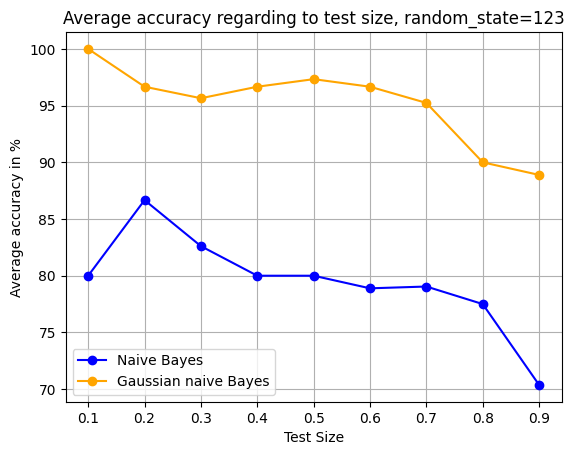

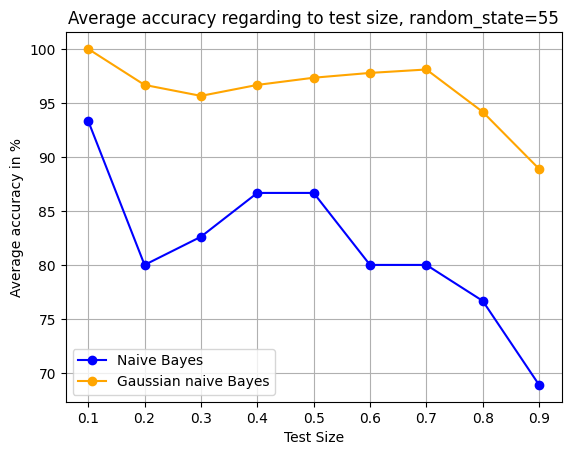